In [3]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [4]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline

In [5]:
pl.style.use('fabiostyle')

# needs to find the library of functions
sys.path.append('../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [6]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [7]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'selectivity_JSB'

In [8]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'update_selectivity', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [9]:
folder = './autorestore/preprocessing'
for var in ('time_ax', 'traces', 'events', 'areas', 'cycles', 'licks', 'rewards',
            'is_rewardt', 'is_CSmt', 'is_rewarded', 'CYCLE_START', 'CS_DURATION', 'DELAY'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))
    
folder = './autorestore/lambo'
for var in ('reward_times', 'is_rewarded'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [10]:
def update_selectivity(selectivity, trial_types, between_what, and_what, append='', append_trial='t'):

    for t in trial_types:

        # this one selects which trials to consider
        which_cycles = eval('is_%s'%(t+append_trial))
#         print sum(which_cycles)

        if not np.any(which_cycles):
            continue
        
        selectivity[t+append] = ut.compute_selectivity(time_ax, events, cycles[which_cycles],
                                                       between_what, and_what)

In [87]:
cs_timeframe = (-CYCLE_START, CS_DURATION-CYCLE_START)
tr_timeframe = (-CYCLE_START+CS_DURATION, -CYCLE_START+CS_DURATION+DELAY)
cs_tr_timeframe = (-CYCLE_START, CS_DURATION-CYCLE_START+DELAY)
us_timeframe = (CS_DURATION-CYCLE_START+DELAY, CS_DURATION-CYCLE_START+DELAY+2)
prebaseline_timeframe = (-CYCLE_START-4, -CYCLE_START-2)
baseline_timeframe = (-CYCLE_START-2, -CYCLE_START)
baseline_cstr_timeframe = (-CYCLE_START-4, -CYCLE_START)
selectivity = {}

update_selectivity(selectivity, ['CSmt', 'rewardt'], cs_timeframe, baseline_timeframe, '', append_trial='')
update_selectivity(selectivity, ['CSmt', 'rewardt'], tr_timeframe, baseline_timeframe, '_tr', append_trial='')
update_selectivity(selectivity, ['CSmt', 'rewardt'], cs_tr_timeframe, baseline_cstr_timeframe, '_cstr', append_trial='')
update_selectivity(selectivity, ['CSmt', 'rewardt'], us_timeframe, baseline_timeframe, '_us', append_trial='')
update_selectivity(selectivity, ['CSmt', 'rewardt'], prebaseline_timeframe, baseline_timeframe, '_prebs', append_trial='')

times = reward_times[is_rewarded]
us_timeframe_licks = np.c_[us_timeframe[0]+times, us_timeframe[0]+times+2]
selectivity['rewardt_licks'] = ut.compute_selectivity(time_ax, events, cycles[is_rewardt][is_rewarded],
                                               us_timeframe_licks, baseline_timeframe)

In [88]:
selectivity.keys()

['CSmt_prebs',
 'rewardt_licks',
 'rewardt',
 'CSmt_cstr',
 'CSmt_tr',
 'rewardt_cstr',
 'CSmt_us',
 'rewardt_prebs',
 'CSmt',
 'rewardt_tr',
 'rewardt_us']

In [78]:
significance = 0.05

for t in np.sort(selectivity.keys()):
    print t, np.mean([s[1]<significance for s in selectivity[t][:, 0]])

CSmt 0.265306122449
CSmt_cstr 0.34693877551
CSmt_prebs 0.204081632653
CSmt_tr 0.387755102041
CSmt_us 0.34693877551
rewardt 0.204081632653
rewardt_cstr 0.326530612245
rewardt_licks 0.183673469388
rewardt_prebs 0.0816326530612
rewardt_tr 0.326530612245
rewardt_us 0.224489795918


In [79]:
significance = 0.05

for t in np.sort(selectivity.keys()):
    print t, np.mean(ut.adjust_pvalues([s[1] for s in selectivity[t][:, 0]])<significance)

CSmt 0.102040816327
CSmt_cstr 0.244897959184
CSmt_prebs 0.0
CSmt_tr 0.244897959184
CSmt_us 0.244897959184
rewardt 0.102040816327
rewardt_cstr 0.285714285714
rewardt_licks 0.0204081632653
rewardt_prebs 0.0
rewardt_tr 0.204081632653
rewardt_us 0.0204081632653


(0, 100)

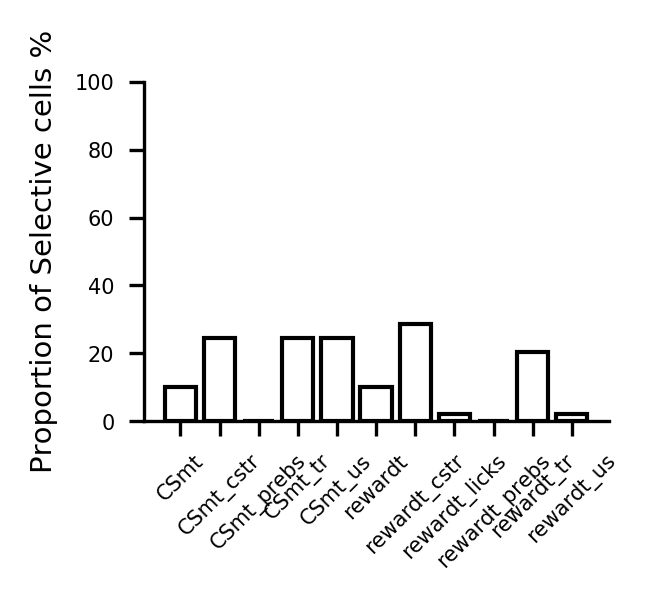

In [80]:
significance = 0.05

fig, ax = pl.subplots(1, 1, figsize=(2, 1.5))
values = [np.mean(ut.adjust_pvalues([s[1] for s in selectivity[t][:, 0]])<significance)*100
          for t in np.sort(selectivity.keys())]
pt.plot_bars(values, ax=ax)
ax.set_xticks(range(len(selectivity)))
ax.set_xticklabels(np.sort(selectivity.keys()), rotation=45)
pt.nicer_plot(ax)
ax.set_ylabel('Proportion of Selective cells %')
ax.set_ylim(0, 100)

In [81]:
for o in ['CSmt', 'rewardt']:
    exec("cells_%s = ut.adjust_pvalues([s[1] for s in selectivity[\'%s\'][:, 0]])<significance"%(o, o))
cells_CSmt_rwt = cells_CSmt*cells_rewardt

In [82]:
tuned_CSmt = np.argwhere(cells_CSmt).flatten()
tuned_rewardt = np.argwhere(cells_rewardt).flatten()

In [83]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
